In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
import glob
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

from tqdm.notebook import tqdm
from pycaret.regression import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 스마트팜 배출량에 대한 예측
- smart_farm_final.csv

# Pycaret을 이용한 튜닝 및 예측
 - 3 표준편차 기준 이상치 대체 반응변수
 - 왜도 3 이상 값들 로그변환 설명변수
 - VIF < 11 인 값들
 - 부스팅 / 배깅 / 블랜딩 3개 혼합모델

In [209]:
#data = pd.read_csv("smart_farm_final.csv").sample(n = 50000)
org_data = pd.read_csv("smart_farm_final.csv")
org_data.shape

(148168, 57)

In [210]:
org_data["환기온도(천창 제어온도)"].value_counts()

28    79025
30    41149
27    27994
Name: 환기온도(천창 제어온도), dtype: int64

시간,년월일 제거

In [211]:
data = org_data.drop(["시간","년월일","년도","월","일","시","분"],axis=1)

In [212]:
train = data.iloc[:129448,:]
test = data.iloc[129448:,:]

문자열 칼럼 추출

In [213]:
# 문자열 형식의 컬럼만 추출하기
object_lst = []

# 숫자 형식의 컬럼만 추출하기
num_lst = []

for col in data.columns:
    if data[col].dtype == "object":
        object_lst.append(col)
    
    else:
        num_lst.append(col)

In [214]:
# 카테고리열 제거한 numerical
# 진짜 숫자 관련 열만 존재

num_lst_real = [x for x in num_lst if x not in ['배기팬','유동팬','팬코일 B동','환기온도(천창 제어온도)', "차광스크린_개방","열공급량(kWh)"]]

object_lst_real = object_lst + ['배기팬','유동팬','팬코일 B동','환기온도(천창 제어온도)', "차광스크린_개방"]

## 변수 선택 이전 스케일링, 로그변환, 이상치 처리

#### 이상치 대체하기

In [191]:
def replace_outlier_zscore(df,columns,n):
    data = df.copy()
    mean = np.mean(data[columns])
    std = np.std(data[columns])
    score_top = int(n)*std + mean
    score_bot = -1*n*std + mean
    
    def cond1(x):
        if x > score_top:
            return score_top
        if x < score_bot:
            return score_bot
        else:
            return x
    data[columns] = data[columns].apply(cond1)
    
    return data[columns]

In [192]:
# data

for col in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도','차광스크린(수평)','차열스크린(수평)',
 '에너지스크린(수평)','에너지스크린(수직)','난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']:
    
    data[col+"_scale"] = data[col]  

이상치 개수 확인

In [193]:
for col in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도','차광스크린(수평)','차열스크린(수평)',
 '에너지스크린(수평)','에너지스크린(수직)','난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']:
    
    data[col+"_scale"] = replace_outlier_zscore(data,col+"_scale",3)
    
    if (data[col] == data[col+"_scale"]).sum() == 148168:
        pass
    else:
        print(col)
        print("이상치 비율 : ",(148168 - (data[col] == data[col+"_scale"]).sum()) / 148168 * 100)
        print(" ---------------------------------------------- ")
        
    data.drop([col+"_scale"],axis=1,inplace=True)

일사량(W/㎡)
이상치 비율 :  0.35500242967442364
 ---------------------------------------------- 
외기온(℃)
이상치 비율 :  0.22541979374763782
 ---------------------------------------------- 
풍속(m/s)
이상치 비율 :  1.6596026132498245
 ---------------------------------------------- 
내부 온도
이상치 비율 :  0.06816586577398628
 ---------------------------------------------- 
내부 습도
이상치 비율 :  0.8773824307542789
 ---------------------------------------------- 
누적강수량
이상치 비율 :  1.9565628205820422
 ---------------------------------------------- 
현지기압
이상치 비율 :  0.6195669780249446
 ---------------------------------------------- 
해면기압
이상치 비율 :  0.6087684250310459
 ---------------------------------------------- 
PM10_1시간
이상치 비율 :  1.5705145510501592
 ---------------------------------------------- 
PM25_1시간
이상치 비율 :  1.4071864370174396
 ---------------------------------------------- 
오존_1시간
이상치 비율 :  0.20247286863560285
 ---------------------------------------------- 
이산화질소_1시간
이상치 비율 :  0.3624264348577291
 ---------------------

이상치 대체하는 함수

In [194]:
for col in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도','차광스크린(수평)','차열스크린(수평)',
 '에너지스크린(수평)','에너지스크린(수직)','난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']:
    
    data[col] = replace_outlier_zscore(data,col,3)

#### 이상치 대체된 것들 확인한번 해보기
- 천창은 0~100 사이의 값을 가지는 수치라서 이상치의 의미가 없음
- 이상치를 값들이 통일되는 장점이 있는 것 같다 : 전체적으로 열공급량 값 자체의 variance가 크지 않아서 유용할 수 있다는 생각

In [ ]:
(data["지면온도"] == data["지면온도_scale"]).sum()

In [ ]:
data[data["지면온도"] != data["지면온도_scale"]][["지면온도","지면온도_scale","열공급량(kWh)"]].to_csv("test.csv",
                                                                                   encoding="utf-8-sig",index=False)

In [ ]:
data["지면온도"].describe()

#### 예측 데이터 편향이 심함
- log1p 변환이 필요함

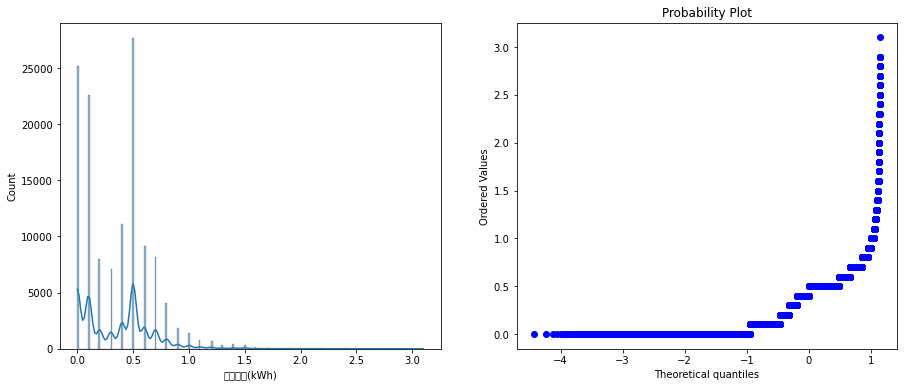

In [20]:
from scipy import stats

fig, axs = plt.subplots(1,2, figsize = (15,6))

sns.histplot(data["열공급량(kWh)"], ax =axs[0], kde=True)
stats.probplot(data["열공급량(kWh)"], dist='norm', fit=True, plot=axs[1])

plt.show()

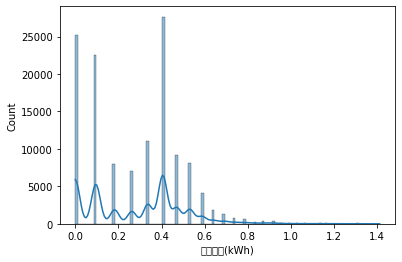

In [82]:
sns.histplot(np.log1p(data["열공급량(kWh)"]), kde=True)
plt.show()

<AxesSubplot:>

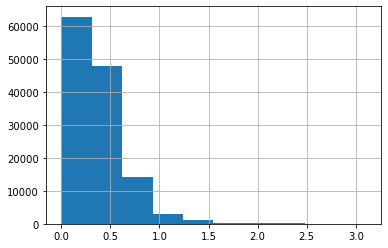

In [46]:
data["열공급량(kWh)"].hist()

<AxesSubplot:>

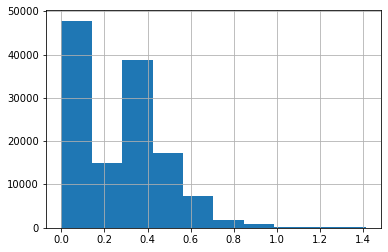

In [48]:
log_y = np.log1p(data["열공급량(kWh)"])
log_y.hist()

#### X값 데이터 편향이 심함
- log1p 변환이 필요한지 확인하기

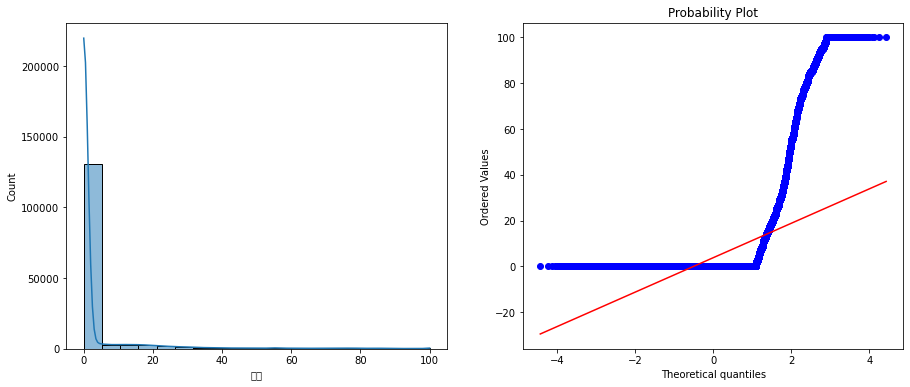

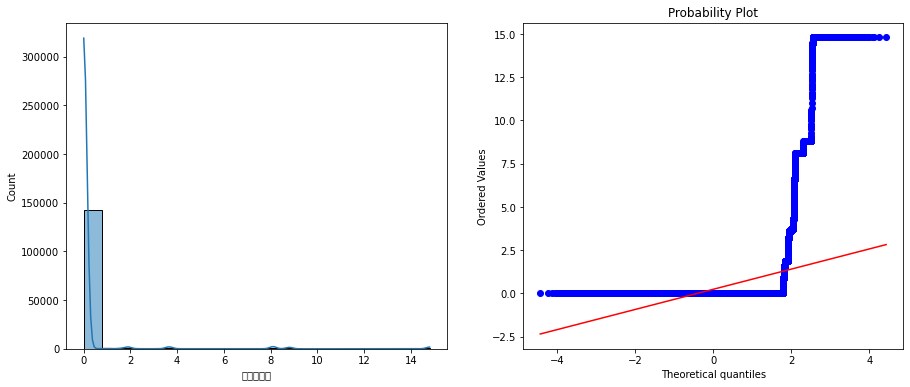

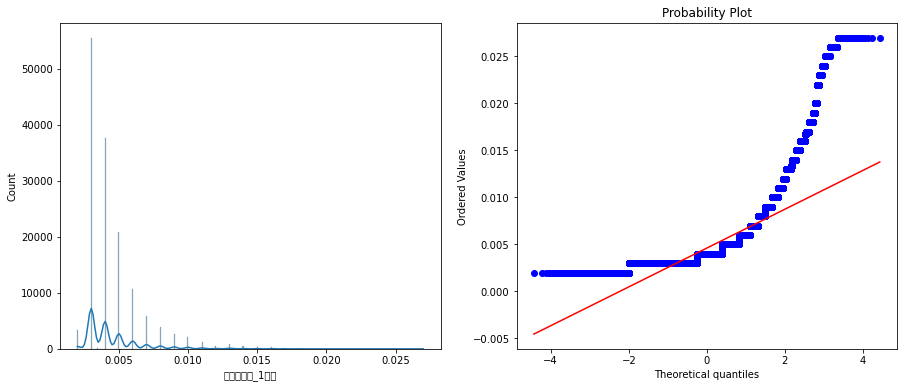

In [214]:
from scipy import stats
# log1p 변환이전의 값
for col in ['천창', '누적강수량', '아황산가스_1시간']:
    fig, axs = plt.subplots(1,2, figsize = (15,6))
    sns.histplot(data[col], ax =axs[0], kde=True)
    stats.probplot(data[col], dist='norm', fit=True, plot=axs[1])

plt.show()

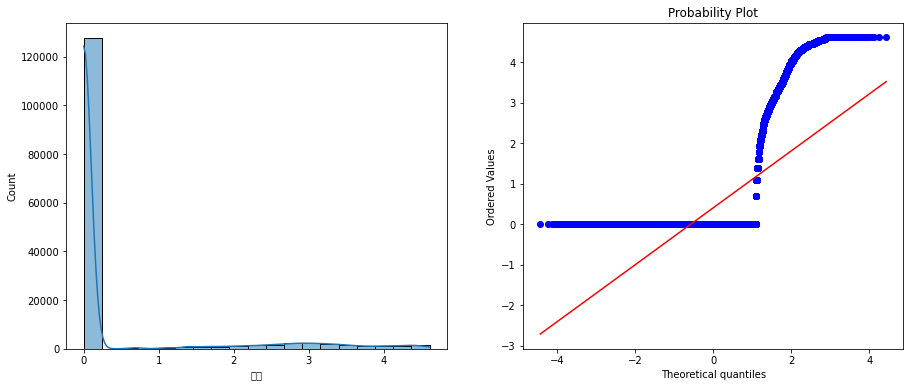

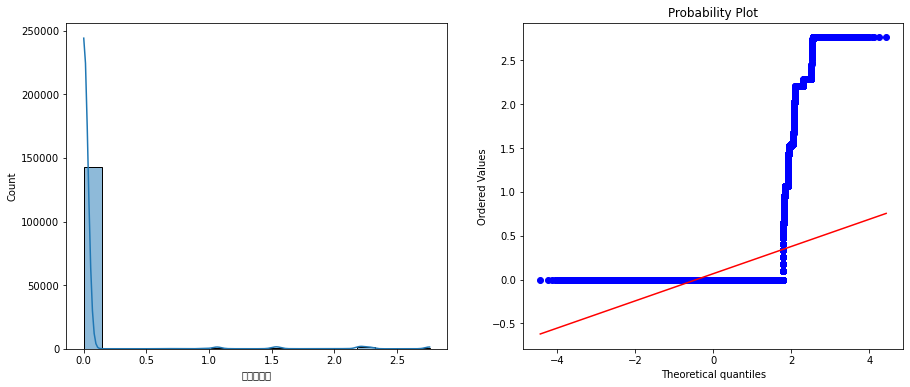

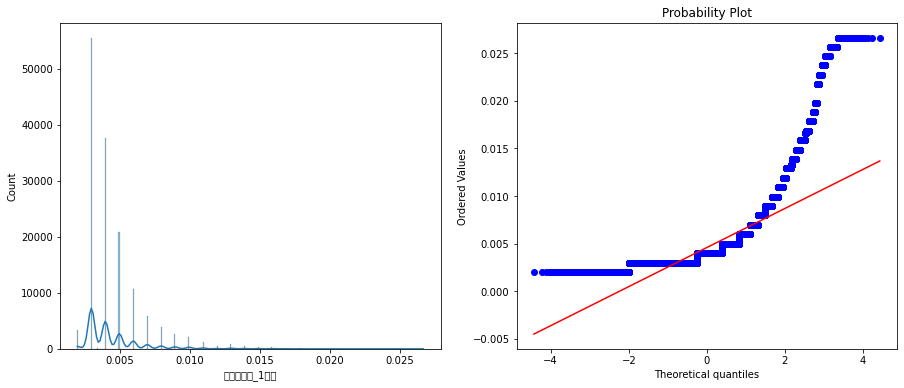

In [59]:
# log1p 변환시도
for col in ['천창', '누적강수량', '아황산가스_1시간']:
    fig, axs = plt.subplots(1,2, figsize = (15,6))
    
    sns.histplot(np.log1p(data[col]), kde=True, ax =axs[0])
    stats.probplot(np.log1p(data[col]), dist='norm', fit=True, plot=axs[1])

plt.show()

In [215]:
loglist=[]
# 왜도 3인 설명변수 log1p 변환
for val in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도','차광스크린(수평)','차열스크린(수평)',
 '에너지스크린(수평)','에너지스크린(수직)','천창','난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']:
    if abs(data[val].skew())>3:
        print("log1p 변환이전 : ",abs(data[val].skew()))
        
        data[val] = np.log1p(data[val])
        loglist.append(val)

        print("log1p 변환이후 : ",abs(np.log1p(data[val]).skew()))
        print("----- 구분선 -----")
        
loglist

log1p 변환이전 :  4.579098139125924
log1p 변환이후 :  2.2492266770097955
----- 구분선 -----
log1p 변환이전 :  7.384725752483332
log1p 변환이후 :  5.308551087130018
----- 구분선 -----
log1p 변환이전 :  3.13108520363669
log1p 변환이후 :  3.0795111004607367
----- 구분선 -----


['천창', '누적강수량', '아황산가스_1시간']

#### 1. 숫자형 데이터 스케일링 진행
- 컬럼별로 스케일링 진행

In [216]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [217]:
data.head()

,일사량(W/㎡),외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),차열스크린(수평),에너지스크린(수평),...,하루길이,시간범주,일몰전후,일출일몰,지면온도,오존등급,아황산가스등급,이산화질소등급,PM10등급,PM25등급
0,0.0,5.8,67,0.0,325,18.3,62.0,0,0,0,...,1004,야간,일몰1시간반_후,일몰,2.7,좋음,좋음,좋음,보통,보통
1,0.0,5.8,67,0.4,344,18.1,63.4,0,0,0,...,1004,야간,일몰1시간반_후,일몰,2.7,좋음,좋음,좋음,보통,보통
2,0.0,5.7,67,0.9,105,17.7,65.2,0,0,0,...,1004,야간,일몰1시간반_후,일몰,2.7,좋음,좋음,좋음,보통,보통
3,0.0,5.7,67,1.3,123,17.7,63.9,0,0,0,...,1004,야간,일몰1시간반_후,일몰,2.7,좋음,좋음,좋음,보통,보통
4,0.0,5.7,67,0.9,123,17.6,64.7,0,0,0,...,1004,야간,일몰1시간반_후,일몰,2.7,좋음,좋음,좋음,보통,보통


In [241]:
for val in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도','차광스크린(수평)','차열스크린(수평)',
 '에너지스크린(수평)','에너지스크린(수직)','천창','난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']:
    
    scaler = StandardScaler()
    
    
    data_scaled = scaler.fit_transform(data[val].values.reshape(-1,1))
    data[val] = data_scaled

In [218]:
for val in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도','차광스크린(수평)','차열스크린(수평)',
 '에너지스크린(수평)','에너지스크린(수직)','천창','난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']:
    
    minmax = MinMaxScaler()
    
    data_scaled = minmax.fit_transform(data[val].values.reshape(-1,1))
    data[val] = data_scaled

"배기팬","유동팬","팬코일 B동","환기온도(천창 제어온도)" 카테고리열 데이터로 스케일링 필요없음

#### 1.1 데이터 처리하기
- 학습용 데이터 : ~2022.03
- 예측용 데이터 : 2022.03~

X 데이터 처리하기
- dummy 처리
- 왜도 처리

In [219]:
data_scaled = data.copy()

In [220]:
data_scaled["년도"] = org_data["년도"]

In [221]:
Y = data_scaled["열공급량(kWh)"]

X_dummy = pd.get_dummies(data_scaled.drop(["열공급량(kWh)"],axis=1)
                         ,columns=["년도"] + object_lst_real)

In [222]:
data_scaled_final = pd.concat([X_dummy, Y], axis = 1)

train_data = data_scaled_final.iloc[:129448,:]

test_data = data_scaled_final.iloc[129448:,:]

### 변수 선택

In [175]:
## 후진 소거법
df = train_data.copy()

variables = df.columns[:-1].tolist() ## 설명 변수 리스트

In [176]:
## 후진 소거법
df = train_data.copy()

variables = df.columns[:-1].tolist() ## 설명 변수 리스트
 
y = df['열공급량(kWh)'] ## 반응 변수
selected_variables = variables ## 초기에는 모든 변수가 선택된 상태
sl_remove = 0.15
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(selected_variables) > 0:
    X = sm.add_constant(df[selected_variables])
    p_vals = sm.OLS(y,X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
    max_pval = p_vals.max() ## 최대 p-value
    if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
        remove_variable = p_vals.idxmax()
        selected_variables.remove(remove_variable)
 
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
        
        print("수정된 결졍계수 ",adj_r_squared)
        
        print("제거된 변수 ",remove_variable)
    else:
        break

수정된 결졍계수  0.29259045046893906
제거된 변수  천창
수정된 결졍계수  0.29259045046893895
제거된 변수  차광스크린_개방조절_80%~100%개방
수정된 결졍계수  0.2925957833645768
제거된 변수  차열스크린(수평)
수정된 결졍계수  0.2925957833645766
제거된 변수  PM25등급_나쁨
수정된 결졍계수  0.29260060492168305
제거된 변수  PM25등급_보통
수정된 결졍계수  0.2926052887105467
제거된 변수  PM10_1시간
수정된 결졍계수  0.29260686036365113
제거된 변수  차광스크린_개방조절_0%~30%개방
수정된 결졍계수  0.29260686036365113
제거된 변수  차열스크린_온도조절_26도이상
수정된 결졍계수  0.29260431970590206
제거된 변수  해면기압
수정된 결졍계수  0.29260431970590195
제거된 변수  일출일몰_일몰
수정된 결졍계수  0.292599463353708
제거된 변수  일출일몰_일출
수정된 결졍계수  0.2925994633537081
제거된 변수  차열스크린_개방조절_70%~100%개방
수정된 결졍계수  0.29259946335370834
제거된 변수  일출1시간후


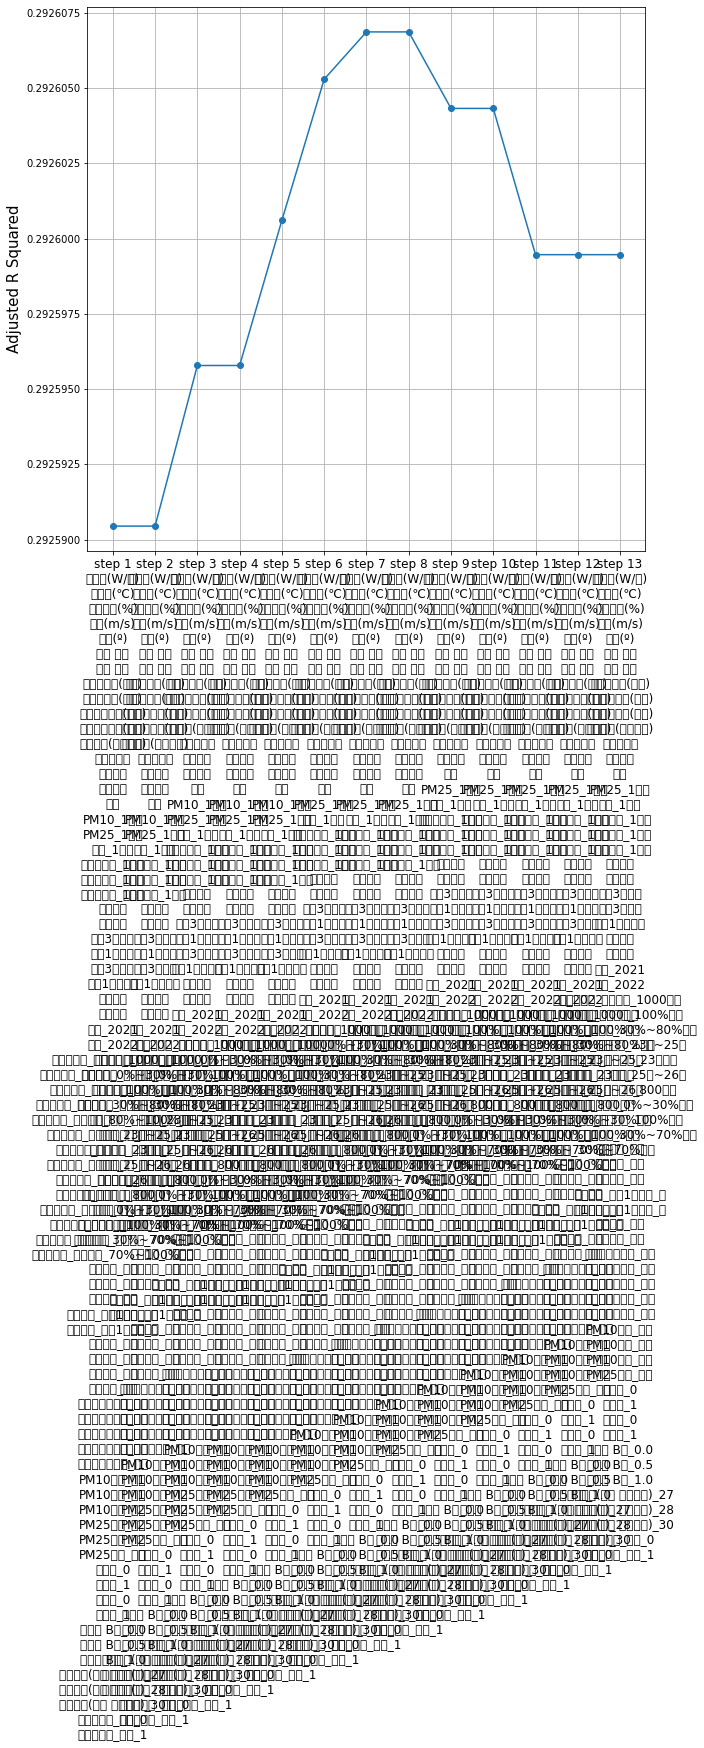

In [177]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [178]:
np.save("backward.npy",selected_variables)

### Stepwise도 선택

In [172]:
## 전진 단계별 선택법

## 후진 소거법
df = train_data.copy()

variables = df.columns[:-1].tolist() ## 설명 변수 리스트
 
y = df['열공급량(kWh)'] ## 반응 변수
selected_variables = []
sl_enter = 0.15
sl_remove = 0.15
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = df[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
        
        print("수정된 결졍계수 ",adj_r_squared)
        
        print("추가된 변수 ",selected_variables[-1])
        
        
    else:
        break

수정된 결졍계수  0.01418313492448342
추가된 변수  오존_1시간
수정된 결졍계수  0.01418313492448231
추가된 변수  차광스크린_광도조절_1000미만
수정된 결졍계수  0.04763103802634816
추가된 변수  아황산가스_1시간
수정된 결졍계수  0.17099269494247404
추가된 변수  에너지스크린(수직)
수정된 결졍계수  0.1845511885282365
추가된 변수  지면온도
수정된 결졍계수  0.24967540137945732
추가된 변수  팬코일 B동_1.0
수정된 결졍계수  0.2594248931259747
추가된 변수  차열스크린_온도조절_23도미만
수정된 결졍계수  0.26449108222219253
추가된 변수  내부 온도
수정된 결졍계수  0.269626128287873
추가된 변수  내부 습도
수정된 결졍계수  0.2746473179537319
추가된 변수  외기온(℃)
수정된 결졍계수  0.2780909725227334
추가된 변수  환기온도(천창 제어온도)_30
수정된 결졍계수  0.2805712607701931
추가된 변수  차열스크린_개방조절_100%개방
수정된 결졍계수  0.282271943254783
추가된 변수  현지기압
수정된 결졍계수  0.28352392047256847
추가된 변수  배기팬_1
수정된 결졍계수  0.28419888401911675
추가된 변수  차광스크린_개방조절_0%~30%개방
수정된 결졍계수  0.2850949573181758
추가된 변수  시간범주_야간
수정된 결졍계수  0.28580963413204596
추가된 변수  외기습도(%)
수정된 결졍계수  0.28635492045168964
추가된 변수  일산화탄소_1시간
수정된 결졍계수  0.28680691092050525
추가된 변수  차열스크린_온도조절_26도이상
수정된 결졍계수  0.2872968932726332
추가된 변수  지면온도
수정된 결졍계수  0.2875902422704052
추가된 변수  차광

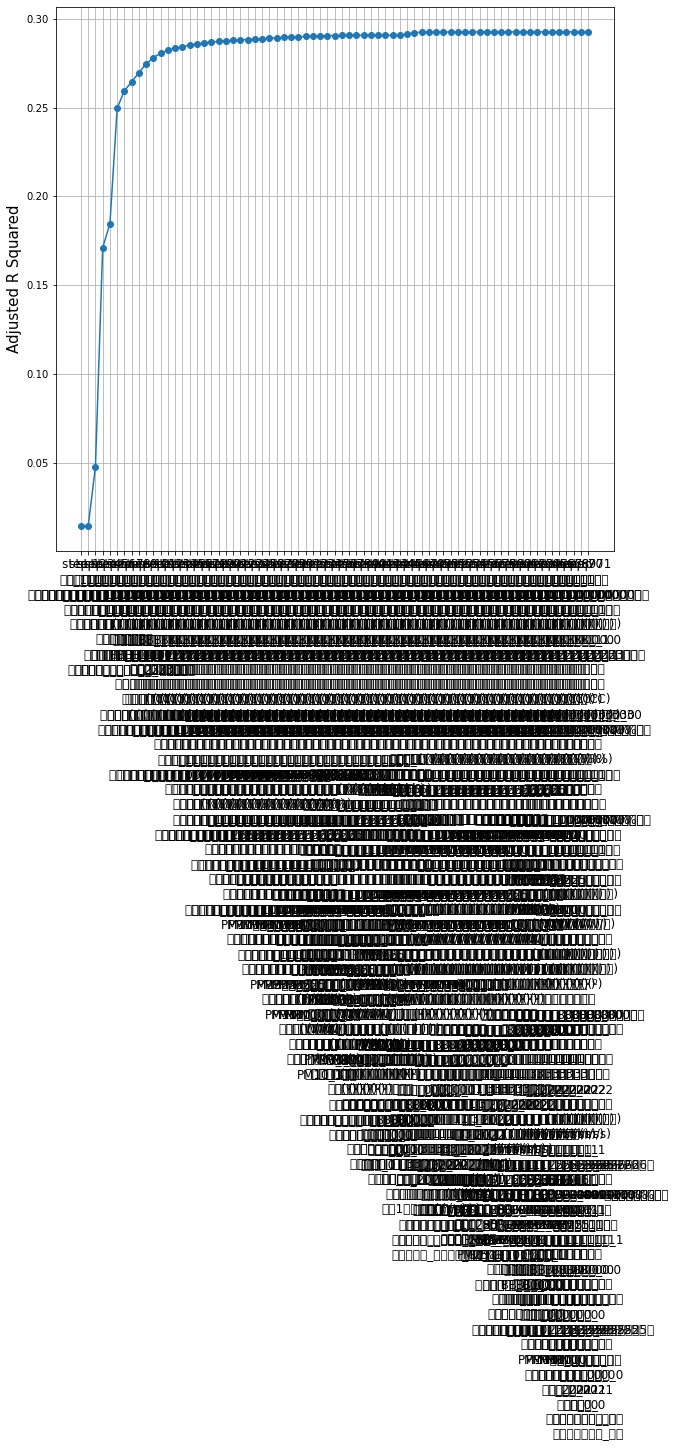

In [173]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [174]:
np.save("stepwise.npy",selected_variables)

58

In [232]:
selected_variables

array(['일사량(W/㎡)', '외기온(℃)', '외기습도(%)', '풍속(m/s)', '풍향(º)', '내부 온도',
       '내부 습도', '차광스크린(수평)', '에너지스크린(수평)', '에너지스크린(수직)', '난방온도(설정온도)',
       '누적강수량', '현지기압', '일조', 'PM25_1시간', '오존_1시간', '이산화질소_1시간',
       '일산화탄소_1시간', '아황산가스_1시간', '일출시간', '일몰시간', '일출3시간후', '일몰3시간후',
       '일몰1시간반전', '하루길이', '지면온도', '년도_2021', '년도_2022',
       '차광스크린_광도조절_1000미만', '차광스크린_개방조절_100%개방', '차광스크린_개방조절_30%~80%개방',
       '차열스크린_온도조절_23도~25도', '차열스크린_온도조절_23도미만', '차열스크린_온도조절_25도~26도',
       '차열스크린_광도조절_800미만', '차열스크린_개방조절_0%~30%개방', '차열스크린_개방조절_100%개방',
       '차열스크린_개방조절_30%~70%개방', '시간범주_그외', '시간범주_야간', '시간범주_주간',
       '일몰전후_일몰1시간반_전', '일몰전후_일몰1시간반_후', '오존등급_보통', '오존등급_좋음',
       '아황산가스등급_보통', '아황산가스등급_좋음', '이산화질소등급_나쁨', '이산화질소등급_보통',
       '이산화질소등급_좋음', 'PM10등급_나쁨', 'PM10등급_보통', 'PM10등급_좋음', 'PM25등급_좋음',
       '배기팬_0', '배기팬_1', '유동팬_0', '유동팬_1', '팬코일 B동_0.0', '팬코일 B동_0.5',
       '팬코일 B동_1.0', '환기온도(천창 제어온도)_27', '환기온도(천창 제어온도)_28',
       '환기온도(천창 제어온도)_30', '차광스크린_개방_0', '차광스크린_개방_1'], dtyp

### 선택된 변수 기반의 예측

- selected_variables : backward로 변수선택
- selected_variables : stepwise로 변수선택
- 2가지 경우 존재

In [223]:
selected_variables = np.load("backward.npy")

In [224]:
x_train = train_data.drop(["열공급량(kWh)"],axis=1)[selected_variables]
y_train = train_data["열공급량(kWh)"]

x_test = test_data.drop(["열공급량(kWh)"],axis=1)[selected_variables]
y_test = test_data["열공급량(kWh)"]

In [225]:
x_train.head(3)

,일사량(W/㎡),외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),에너지스크린(수평),에너지스크린(수직),...,유동팬_0,유동팬_1,팬코일 B동_0.0,팬코일 B동_0.5,팬코일 B동_1.0,환기온도(천창 제어온도)_27,환기온도(천창 제어온도)_28,환기온도(천창 제어온도)_30,차광스크린_개방_0,차광스크린_개방_1
0,0.0,0.495238,0.643678,0.000000,0.901408,0.359322,0.485804,0.0,0.0,0.0,...,0,1,1,0,0,0,1,0,1,0
1,0.0,0.495238,0.643678,0.024242,0.954930,0.352542,0.507886,0.0,0.0,0.0,...,0,1,1,0,0,0,1,0,1,0
2,0.0,0.492063,0.643678,0.054545,0.281690,0.338983,0.536278,0.0,0.0,0.0,...,0,1,0,0,1,0,1,0,1,0


#### 설명변수 log변환 없이 진행

In [236]:
np.log1p(y_train).describe()

count    129448.000000
mean          0.281012
std           0.218423
min           0.000000
25%           0.095310
50%           0.336472
75%           0.405465
max           1.410987
Name: 열공급량(kWh), dtype: float64

In [237]:
y_train.describe()

count    129448.000000
mean          0.357508
std           0.315677
min           0.000000
25%           0.100000
50%           0.400000
75%           0.500000
max           3.100000
Name: 열공급량(kWh), dtype: float64

In [47]:
data = pd.concat([x_train,y_train],axis=1)
data.shape

(129448, 67)

In [48]:
data.head(2)

,일사량(W/㎡),외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),에너지스크린(수평),에너지스크린(수직),난방온도(설정온도),누적강수량,현지기압,일조,PM25_1시간,오존_1시간,이산화질소_1시간,일산화탄소_1시간,아황산가스_1시간,일출시간,일몰시간,일출3시간후,일몰3시간후,일몰1시간반전,하루길이,지면온도,년도_2021,년도_2022,차광스크린_광도조절_1000미만,차광스크린_개방조절_100%개방,차광스크린_개방조절_30%~80%개방,차열스크린_온도조절_23도~25도,차열스크린_온도조절_23도미만,차열스크린_온도조절_25도~26도,차열스크린_광도조절_800미만,차열스크린_개방조절_0%~30%개방,차열스크린_개방조절_100%개방,차열스크린_개방조절_30%~70%개방,시간범주_그외,시간범주_야간,시간범주_주간,일몰전후_일몰1시간반_전,일몰전후_일몰1시간반_후,오존등급_보통,오존등급_좋음,아황산가스등급_보통,아황산가스등급_좋음,이산화질소등급_나쁨,이산화질소등급_보통,이산화질소등급_좋음,PM10등급_나쁨,PM10등급_보통,PM10등급_좋음,PM25등급_좋음,배기팬_0,배기팬_1,유동팬_0,유동팬_1,팬코일 B동_0.0,팬코일 B동_0.5,팬코일 B동_1.0,환기온도(천창 제어온도)_27,환기온도(천창 제어온도)_28,환기온도(천창 제어온도)_30,차광스크린_개방_0,차광스크린_개방_1,열공급량(kWh)
0,0.0,0.495238,0.643678,0.000000,0.901408,0.359322,0.485804,0.0,0.0,0.0,0.5,0.0,0.506494,29180.0,0.283784,0.02381,0.320513,0.142857,0.040477,713,1717,1013,2017,1547,1004,0.254545,1,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1,0,0.9
1,0.0,0.495238,0.643678,0.024242,0.954930,0.352542,0.507886,0.0,0.0,0.0,0.5,0.0,0.506494,0.0,0.283784,0.02381,0.320513,0.142857,0.040477,713,1717,1013,2017,1547,1004,0.254545,1,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1,0,0.9


In [49]:
reg_lunch=setup(
        data=data,
        target='열공급량(kWh)',
        train_size=0.8,
        session_id = 0,
        imputation_type='simple',
        data_split_shuffle=False,
        normalize = False,
        fold_strategy = 'timeseries',
        fold = 5,
        verbose=True,
        silent= True, n_jobs= 1)

,Description,Value
0,session_id,0
1,Target,열공급량(kWh)
2,Original Data,"(129448, 67)"
3,Missing Values,False
4,Numeric Features,66
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(103558, 56)"


In [50]:
best_5_d = compare_models(sort = 'RMSLE', n_select = 5,round=4,cross_validation=True,verbose=True)
print(best_5_d)

IntProgress(value=0, description='Processing: ', max=89)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:37:15
Status,. . . . . . . . . . . . . . . . . .,Finalizing Model
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,0.1891,0.0700,0.2634,0.1561,0.1857,0.7126,0.0360
huber,Huber Regressor,0.2209,0.0884,0.2934,-0.0616,0.2035,0.7451,3.1500
lasso,Lasso Regression,0.2378,0.0855,0.2918,-0.0334,0.2099,0.8132,0.0400
en,Elastic Net,0.2381,0.0857,0.2921,-0.0353,0.2100,0.8111,0.5680
llar,Lasso Least Angle Regression,0.2423,0.0861,0.2928,-0.0405,0.2112,0.8313,0.0340
knn,K Neighbors Regressor,0.2179,0.1004,0.3161,-0.2184,0.2182,0.7130,1.4440
br,Bayesian Ridge,0.2497,0.1078,0.3166,-0.2785,0.2210,0.9474,0.2540
ridge,Ridge Regression,0.2499,0.1080,0.3168,-0.2812,0.2212,0.9476,0.0340
par,Passive Aggressive Regressor,0.2693,0.1360,0.3640,-0.6418,0.2307,1.0238,0.1260
lr,Linear Regression,0.3174,0.1649,0.3838,-0.9730,0.2613,1.1992,0.0620


KeyboardInterrupt: 

### 설명변수 log1p 변환이 성능을 높여줌

In [226]:
data_transform = pd.concat([x_train,np.log1p(y_train)],axis=1)
data_transform.shape

(129448, 67)

In [227]:
reg_lunch_transform = setup(
        data=data_transform,
        target='열공급량(kWh)',
        train_size=0.8,
        session_id = 0,
        imputation_type='simple',
        data_split_shuffle=False,
        normalize = False,
        fold_strategy = 'timeseries',
        fold = 5,
        verbose=True,
        silent= True, n_jobs= 1)

,Description,Value
0,session_id,0
1,Target,열공급량(kWh)
2,Original Data,"(129448, 67)"
3,Missing Values,False
4,Numeric Features,66
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(103558, 56)"


단일 모델 선택하기 위한 성능 비교

In [228]:
best_5_d = compare_models(sort = 'RMSLE', n_select = 5,round=4,cross_validation=True,verbose=True,errors='ignore')
print(best_5_d)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,0.1388,0.0332,0.1815,0.2069,0.1411,0.5587,0.0400
ada,AdaBoost Regressor,0.1373,0.0327,0.1801,0.2225,0.1413,0.6006,3.3120
et,Extra Trees Regressor,0.1388,0.0342,0.1834,0.1873,0.1425,0.5735,18.0840
lightgbm,Light Gradient Boosting Machine,0.1339,0.0344,0.1830,0.1873,0.1426,0.5962,0.5560
gbr,Gradient Boosting Regressor,0.1381,0.0347,0.1837,0.1787,0.1427,0.6061,9.6680
rf,Random Forest Regressor,0.1420,0.0367,0.1899,0.1281,0.1476,0.6022,33.7020
lasso,Lasso Regression,0.1779,0.0431,0.2072,-0.0277,0.1630,0.6547,0.0480
en,Elastic Net,0.1779,0.0431,0.2073,-0.0278,0.1630,0.6546,0.0460
llar,Lasso Least Angle Regression,0.1821,0.0437,0.2087,-0.0415,0.1644,0.6734,0.0420
knn,K Neighbors Regressor,0.1581,0.0473,0.2171,-0.1358,0.1664,0.5903,1.3900


[OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None), AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=0), ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
                    verbose=0, warm_start=False), LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators

#### 성능 테스트 실험
- 타겟 데이터 log 변환 시 성능 상승
- 이상치 대체하기
- 왜도가 높은 것들 log 변환

실험 1
- 타겟 데이터 log 변환 X
- 이상치 대체하기
- 왜도가 높은 것들 log 변환
- Normalization
- Backward 변수선택

In [55]:
from IPython.display import Image  # 주피터 노트북에 이미지 삽입

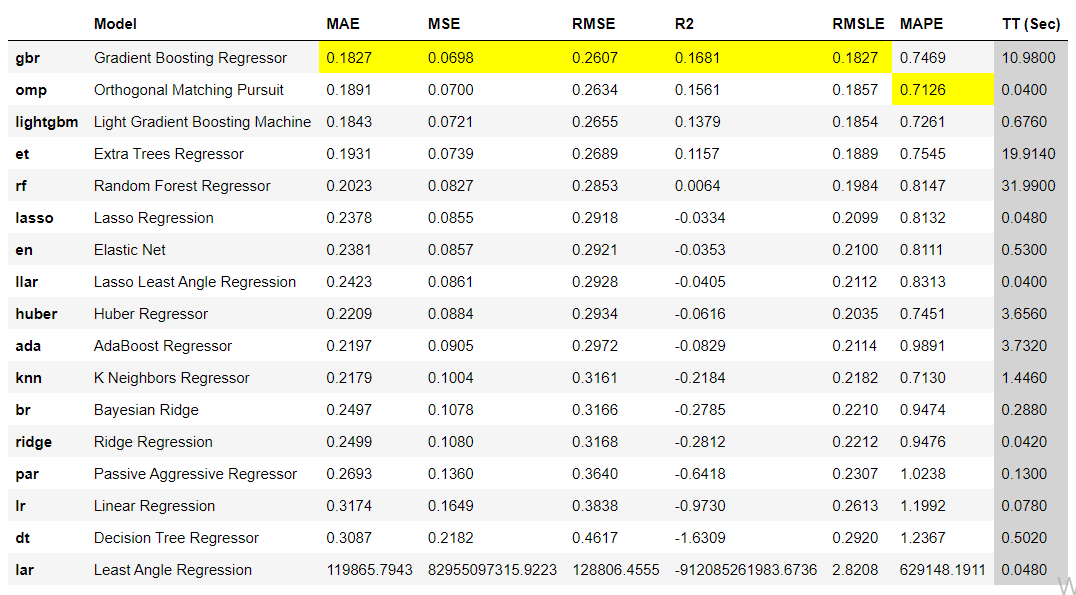

In [202]:
Image("test1.png")

실험 2
- 타겟 데이터 log 변환 O
- 이상치 대체하기
- 왜도가 높은 것들 log 변환
- Normalization
- Backward 변수선택

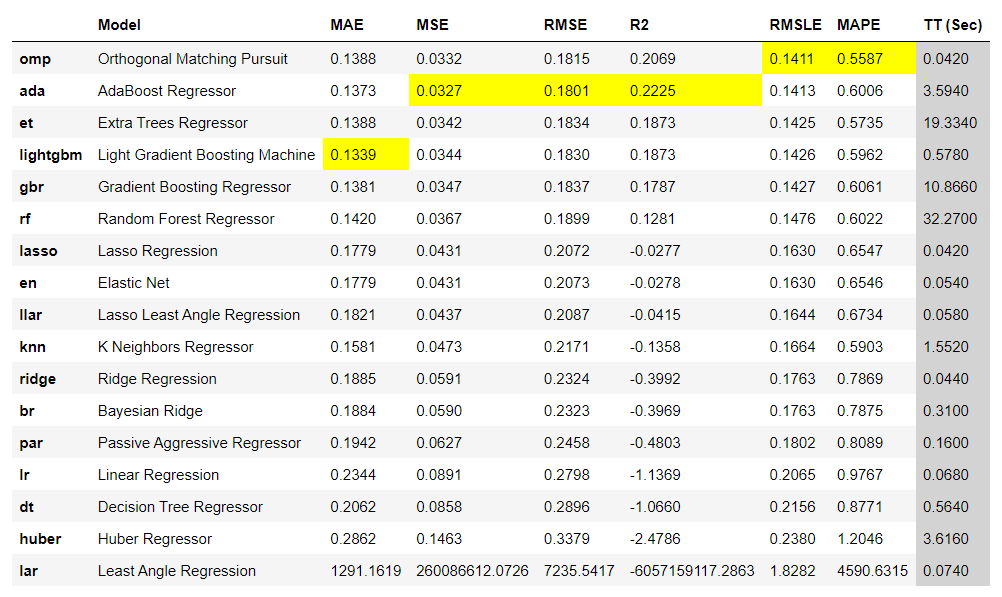

In [203]:
Image("test2.png")

실험 3
- 타겟 데이터 log 변환 O
- 이상치 대체하기 X
- 왜도가 높은 것들 log 변환 X
- StandardScaler
- Backward 변수선택

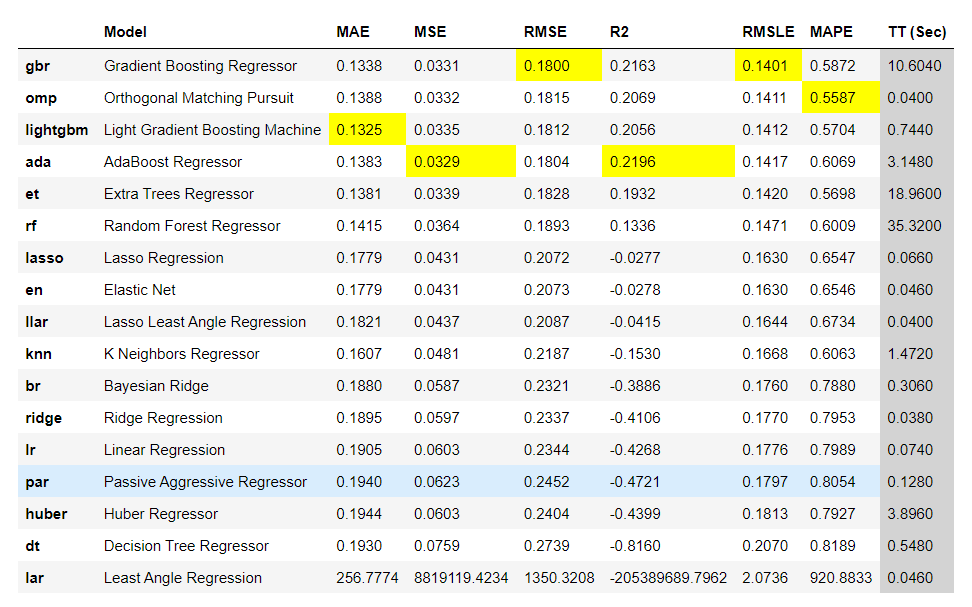

In [253]:
Image("test3.png")

실험 4
- 타겟 데이터 log 변환 O
- 이상치 대체하기 X
- 왜도가 높은 것들 log 변환 X
- Normalization
- Backward 변수선택

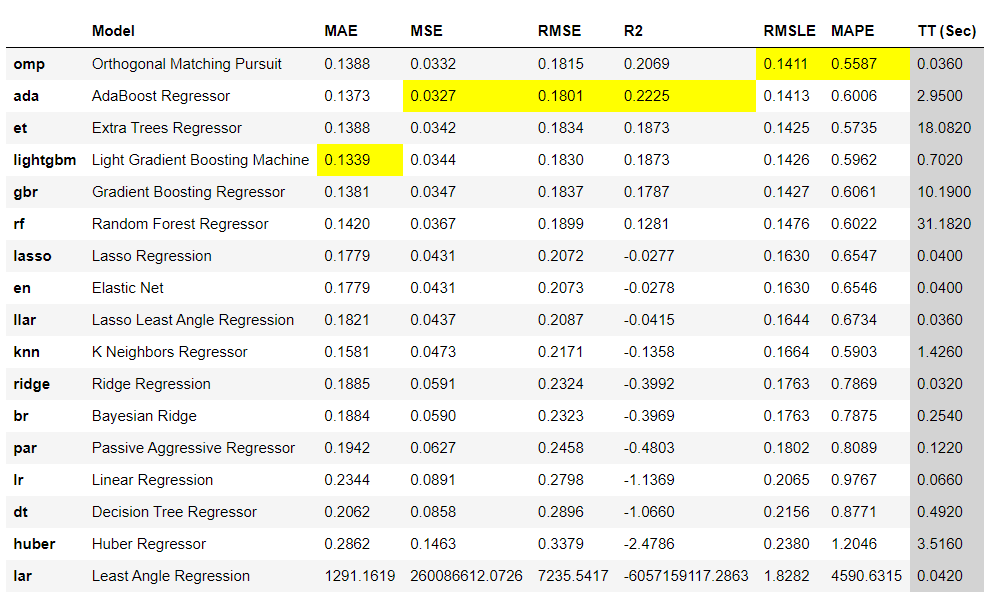

In [56]:
Image("test4.png")

실험 4에 모델을 다르게 한번 적용해보기 -> Gradient Boosting Regressor

실험 5
- 타겟 데이터 log 변환 O
- 이상치 대체하기 
- 왜도가 높은 것들 log 변환 X
- Normalization
- Backward 변수선택

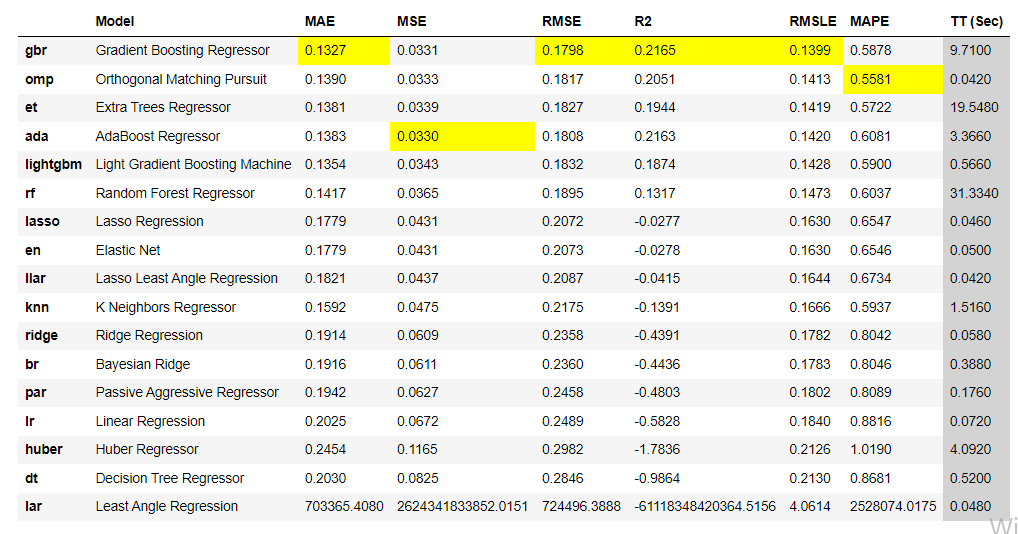

In [208]:
Image("test5.png")

실험 6
- 타겟 데이터 log 변환 O
- 이상치 대체하기 X
- 왜도가 높은 것들 log 변환
- Normalization
- Backward 변수선택

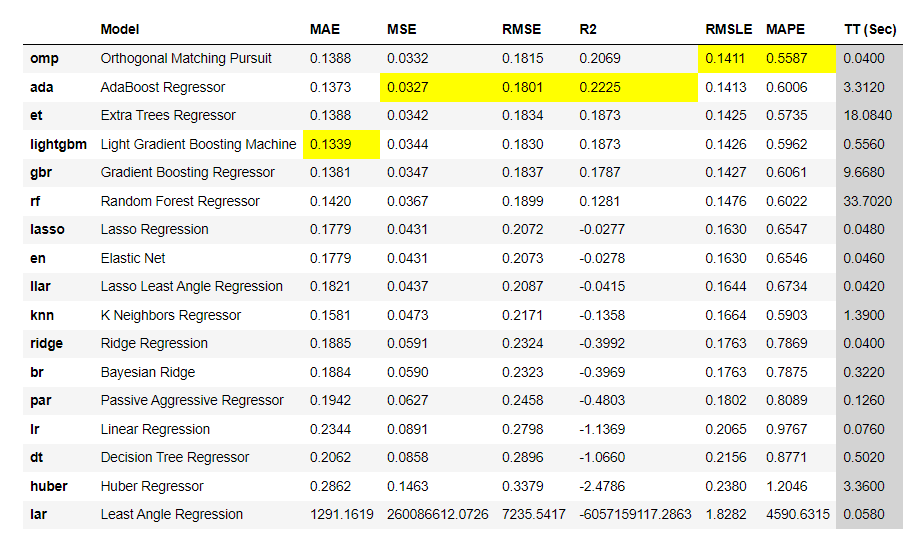

In [230]:
Image("test6.png")

### 모델 생성 및 튜닝
- ada boost
- orthogonal mathcing pursuit

In [181]:
omp_model = create_model("omp")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1656,0.0438,0.2094,0.0386,0.1669,0.8838
1,0.1409,0.0335,0.1829,0.1001,0.1376,0.4457
2,0.1352,0.0340,0.1843,0.2086,0.1407,0.4816
3,0.1300,0.0273,0.1652,0.3473,0.1305,0.5159
4,0.1221,0.0275,0.1658,0.3401,0.1299,0.4667
Mean,0.1388,0.0332,0.1815,0.2069,0.1411,0.5587
SD,0.0148,0.0060,0.0161,0.1243,0.0135,0.1641


In [182]:
ada_model = create_model("ada")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1674,0.0445,0.2110,0.0230,0.1677,0.9085
1,0.1194,0.0271,0.1648,0.2699,0.1282,0.4981
2,0.1322,0.0348,0.1865,0.1903,0.1430,0.4800
3,0.1416,0.0292,0.1709,0.3012,0.1364,0.5944
4,0.1261,0.0280,0.1673,0.3281,0.1314,0.5223
Mean,0.1373,0.0327,0.1801,0.2225,0.1413,0.6006
SD,0.0167,0.0065,0.0172,0.1099,0.0141,0.1588


In [73]:
tuned_models = []

ada_model = tune_model(ada_model, fold= 3, n_iter = 100, optimize = 'R2', verbose = True, choose_better = True)
tuned_models.append(ada_model)

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:37:15
Status,. . . . . . . . . . . . . . . . . .,Finalizing Model
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,MAE,MSE,RMSE,R2,RMSLE,MAPE


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [78]:
omp_model = create_model("omp")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1656,0.0438,0.2094,0.0386,0.1669,0.8838
1,0.1409,0.0335,0.1829,0.1001,0.1376,0.4457
2,0.1352,0.0340,0.1843,0.2086,0.1407,0.4816
3,0.1300,0.0273,0.1652,0.3473,0.1305,0.5159
4,0.1221,0.0275,0.1658,0.3401,0.1299,0.4667
Mean,0.1388,0.0332,0.1815,0.2069,0.1411,0.5587
SD,0.0148,0.0060,0.0161,0.1243,0.0135,0.1641


In [79]:
import math
import time

In [80]:
start = time.time()

tuned_models = []

omp_model = tune_model(omp_model, fold= 3, n_iter = 100, optimize = 'R2', verbose = True, choose_better = True)
tuned_models.append(omp_model)

math.factorial(100000)
end = time.time()

print(f"{end - start:.5f} sec")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1628,0.0411,0.2026,-0.0136,0.1537,0.6035
1,0.1211,0.0299,0.1729,0.2902,0.1328,0.4295
2,0.1304,0.0286,0.1691,0.3247,0.1325,0.5093
Mean,0.1381,0.0332,0.1816,0.2004,0.1397,0.5141
SD,0.0179,0.0056,0.0150,0.1520,0.0100,0.0711


12.40907 sec


모델 저장하기
- adaboost_ver1
- 타겟 데이터 log 변환 O
- 이상치 대체하기 X
- 왜도가 높은 것들 log 변환 X
- Normalization

In [343]:
import joblib
joblib.dump(ada_model, 'adaboost_ver1.pkl')
# model = joblib.load('adaboost_ver1.pkl') : 모델 읽어오기

['adaboost_ver1.pkl']

모델 불러오기

In [136]:
import joblib
ada_model = joblib.load('adaboost_ver1.pkl')

모델로 예측하기

In [166]:
final_model = omp_model

In [167]:
prediction = predict_model(final_model, data = x_test)

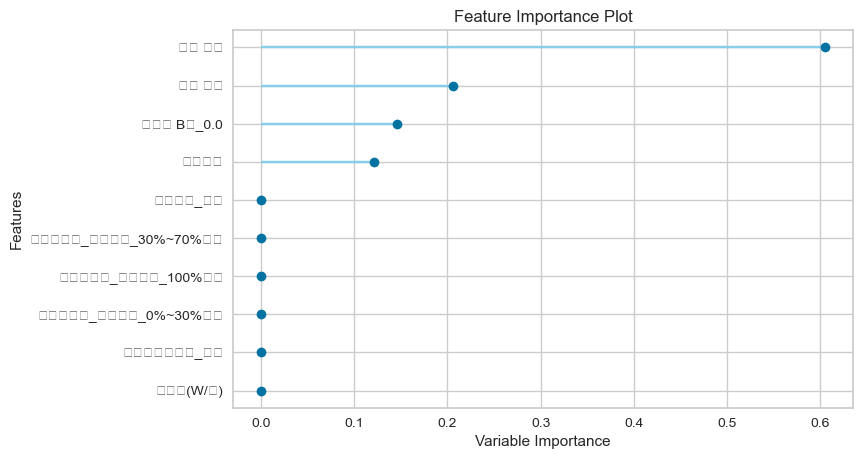

,Feature,Value
0,일사량(W/㎡),0.048684
1,외기온(℃),0.048684
30,차열스크린_온도조절_25도~26도,0.048684
31,차열스크린_광도조절_800미만,0.048684
32,차열스크린_개방조절_0%~30%개방,0.048684
33,차열스크린_개방조절_100%개방,0.048684
34,차열스크린_개방조절_30%~70%개방,0.048684
35,시간범주_그외,0.048684
36,시간범주_야간,0.048684
37,시간범주_주간,0.048684


In [231]:
lr = create_model('lr')
plot_model(final_model, plot = 'feature')

# this is how you can recreate the table
import pandas as pd
pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(lr.coef_[0])}).sort_values(by='Value', ascending=False)

#### 로그역변환 반드시 하기

In [168]:
prediction["Label"]

129448    0.386486
129449    0.389202
129450    0.389968
129451    0.389886
129452    0.390097
            ...   
148163    0.217120
148164    0.219690
148165    0.217740
148166    0.217718
148167    0.219263
Name: Label, Length: 18720, dtype: float64

In [169]:
predict_df = org_data.iloc[129448:,:].copy()
predict_df["열공급량(kWh)"] = prediction["Label"].apply(lambda x : np.exp(x)-1)

In [170]:
predict_df["년월일"].value_counts()

2022-03-12    1440
2022-03-08    1440
2022-03-11    1440
2022-03-13    1440
2022-03-20    1440
2022-03-05    1440
2022-03-19    1440
2022-03-06    1440
2022-03-07    1440
2022-03-04    1440
2022-03-18    1440
2022-03-09    1440
2022-03-10    1440
Name: 년월일, dtype: int64

In [171]:
predict_df[["년월일","열공급량(kWh)"]].head()

,년월일,열공급량(kWh)
129448,2022-03-04,0.471799
129449,2022-03-04,0.475803
129450,2022-03-04,0.476933
129451,2022-03-04,0.476812
129452,2022-03-04,0.477124


In [172]:
predict_df.rename(columns={'년도':'yy'},inplace=True)
predict_df.rename(columns={'월':'mm'},inplace=True)
predict_df.rename(columns={'일':'dd'},inplace=True)

제출용 데이터로 가공하기

In [173]:
submit_df = pd.read_csv("2-1_검증데이터셋.csv")

In [174]:
submit_df = pd.merge(submit_df[["yy","mm","dd"]],predict_df[["yy","mm","dd","시","분","열공급량(kWh)"]],
                     on = ["yy","mm","dd"], how = "inner").reset_index()

submit_df = submit_df.groupby(["yy","mm","dd"]).sum().reset_index()

In [175]:
submit_df.drop(["index","시","분"],axis=1,inplace=True)

In [176]:
submit_df.rename(columns={'열공급량(kWh)':'heat_supply_day'},inplace=True)

In [150]:
submit_df.to_csv("220104_ada_model_ver1.1.csv",encoding="utf-8-sig",index=False)

plot 그려보기

In [161]:
predict_df[["년월일","시","분","열공급량(kWh)"]]

,년월일,시,분,열공급량(kWh)
129448,2022-03-04,0,0,0.141266
129449,2022-03-04,0,1,0.300338
129450,2022-03-04,0,2,0.300338
129451,2022-03-04,0,3,0.300338
129452,2022-03-04,0,4,0.300338
...,...,...,...,...
148163,2022-03-20,23,55,0.141266
148164,2022-03-20,23,56,0.141266
148165,2022-03-20,23,57,0.141266
148166,2022-03-20,23,58,0.141266


In [177]:
compare_df = pd.concat([org_data[["년월일","시","분","열공급량(kWh)"]].iloc[:129448,:],
                       predict_df[["년월일","시","분","열공급량(kWh)"]]],
                      ignore_index = True)

In [178]:
compare = compare_df.groupby(["년월일"]).sum().reset_index()

In [179]:
#compare[["년월일","열공급량(kWh)"]].to_csv("test.csv",encoding="utf-8-sig",index=False)

<AxesSubplot:xlabel='년월일'>

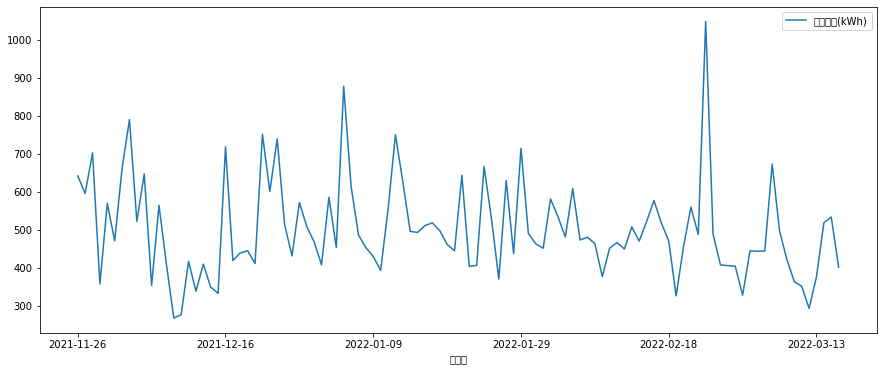

In [180]:
fig, ax = plt.subplots(1,1, figsize = (15,6))
compare[["년월일","열공급량(kWh)"]].set_index("년월일").plot(ax=ax)